In [ ]:
## LSTM Model with Keras/Tensorflow

In [1]:
import re
import os
import math
import nltk
import time
import re
import string
import pandas as pd
from nltk.corpus import stopwords

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [3]:
LSTM_df = pd.read_excel(r'C:\Users\jeffd\Documents\Studying\Statistical Software\Final Project\Input_project_v11_age.xlsx')
LSTM_df = LSTM_df.astype(str)

In [4]:
LSTM_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

,age,age_group,status,sex,orientation,body_type,diet,drinks,drinks_freq,drugs,...,job_group,last_online,location,offspring,pets,religion,sign,smokes,speaks,Bio
0,22,18_22,single,m,straight,a little extra,strictly anything,socially,1,never,...,blue_collar,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...
1,22,18_22,single,f,straight,athletic,nan,socially,1,never,...,student,2012-06-15-22-56,"san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,catholicism and somewhat serious about it,taurus but it doesn&rsquo;t matter,no,"english (fluently), spanish (fluently), italia...",my name is ashley and i live in san francisco....
2,22,18_22,single,m,straight,fit,mostly anything,socially,1,never,...,business,2012-06-10-01-37,"san francisco, california",nan,likes dogs and dislikes cats,catholicism and laughing about it,leo and it&rsquo;s fun to think about,trying to quit,"english (fluently), tagalog (fluently), japane...","full-time student, full-time square. i change ..."
3,20,18_22,single,f,straight,average,mostly vegetarian,socially,1,never,...,blue_collar,2012-06-30-00-00,"san rafael, california",doesn't want kids,has dogs and likes cats,nan,cancer,no,"english (fluently), spanish (fluently)","""apparently,"" has become a new favorite word o..."
4,21,18_22,single,m,straight,thin,nan,socially,1,nan,...,s.t.e.m.,2012-06-29-22-10,"san francisco, california",nan,nan,buddhism,nan,when drinking,english,"i grew up in iowa. it gets a bad rap, but let ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,65,51+,single,f,straight,fit,nan,socially,1,never,...,humanities_arts_entertainment,2011-08-19-18-51,"oakland, california",nan,nan,nan,libra but it doesn&rsquo;t matter,no,english (fluently),my friends describe me as a beautiful on the i...
10846,55,51+,single,f,straight,full figured,anything,rarely,0,never,...,business,2012-06-19-08-45,"half moon bay, california","has kids, but doesn't want more",dislikes cats,catholicism but not too serious about it,leo but it doesn&rsquo;t matter,no,english,"my friends would say i've got a caring, nurtur..."
10847,51,51+,single,m,straight,average,strictly anything,rarely,0,never,...,business,2012-06-30-06-26,"san francisco, california",has a kid,nan,atheism but not too serious about it,nan,sometimes,english,in the suburbs not by choice but necessity. i ...
10848,65,51+,single,f,straight,curvy,mostly anything,socially,1,never,...,other,2012-06-30-19-11,"san lorenzo, california",has kids,has dogs and has cats,catholicism and very serious about it,scorpio and it matters a lot,no,"english, english, french, spanish",i am fun loving and romantic. a bouquet of flo...


In [5]:
LSTM_df["Bio"] = LSTM_df["Bio"].str.lower()

In [6]:
#df['Bio'].str.lower()
bio_token_LSTM = pd.DataFrame(LSTM_df, columns = ['Bio'])
print(bio_token_LSTM[0:5])

                                                 Bio
0  about me:  i would love to think that i was so...
1  my name is ashley and i live in san francisco....
2  full-time student, full-time square. i change ...
3  "apparently," has become a new favorite word o...
4  i grew up in iowa. it gets a bad rap, but let ...


In [7]:
import nltk

LSTM_df['Bio'] = LSTM_df['Bio'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
LSTM_df['Bio'] = LSTM_df['Bio'].str.replace(".", "").str.replace(",", "").str.strip()
LSTM_df['Bio'] = LSTM_df['Bio'].str.replace(")", "").str.replace("(", "").str.strip()
LSTM_df['Bio'] = LSTM_df['Bio'].str.replace("!@#$%^&*\(\)\[]\{};:,./<>?\|`~=_+", "").str.strip()


In [8]:
df_dating_top_LSTM = LSTM_df.head()
df_dating_top_LSTM

,age,age_group,status,sex,orientation,body_type,diet,drinks,drinks_freq,drugs,...,job_group,last_online,location,offspring,pets,religion,sign,smokes,speaks,Bio
0,22,18_22,single,m,straight,a little extra,strictly anything,socially,1,never,...,blue_collar,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me i would love to think that i was some...
1,22,18_22,single,f,straight,athletic,nan,socially,1,never,...,student,2012-06-15-22-56,"san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,catholicism and somewhat serious about it,taurus but it doesn&rsquo;t matter,no,"english (fluently), spanish (fluently), italia...",my name is ashley and i live in san francisco ...
2,22,18_22,single,m,straight,fit,mostly anything,socially,1,never,...,business,2012-06-10-01-37,"san francisco, california",nan,likes dogs and dislikes cats,catholicism and laughing about it,leo and it&rsquo;s fun to think about,trying to quit,"english (fluently), tagalog (fluently), japane...",fulltime student fulltime square i change from...
3,20,18_22,single,f,straight,average,mostly vegetarian,socially,1,never,...,blue_collar,2012-06-30-00-00,"san rafael, california",doesn't want kids,has dogs and likes cats,nan,cancer,no,"english (fluently), spanish (fluently)",apparently has become a new favorite word of m...
4,21,18_22,single,m,straight,thin,nan,socially,1,nan,...,s.t.e.m.,2012-06-29-22-10,"san francisco, california",nan,nan,buddhism,nan,when drinking,english,i grew up in iowa it gets a bad rap but let me...


In [9]:
LSTM_df = LSTM_df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
LSTM_df['Bio'] = LSTM_df['Bio'].apply(clean_text)
LSTM_df['Bio'] = LSTM_df['Bio'].str.replace('\d+', '')

In [10]:
print(LSTM_df['Bio'][1:5])

1    name ashley live san francisco love dance spea...
2    fulltime student fulltime square change year y...
3    apparently become new favorite word mine like ...
4    grew iowa gets bad rap let first tell youiowa ...
Name: Bio, dtype: object


In [11]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(LSTM_df['Bio'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 92154 unique tokens.


In [12]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(LSTM_df['Bio'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10850, 250)


In [13]:
Y = pd.get_dummies(LSTM_df['drinks']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10850, 6)


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8680, 250) (8680, 6)
(2170, 250) (2170, 6)


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
109/109 [==============================] - 83s 739ms/step - loss: 1.0432 - accuracy: 0.7095 - val_loss: 0.9329 - val_accuracy: 0.7235
Epoch 2/5
109/109 [==============================] - 76s 701ms/step - loss: 0.9213 - accuracy: 0.7182 - val_loss: 0.9428 - val_accuracy: 0.7224
Epoch 3/5
109/109 [==============================] - 74s 678ms/step - loss: 0.7694 - accuracy: 0.7383 - val_loss: 1.0191 - val_accuracy: 0.7126
Epoch 4/5
109/109 [==============================] - 74s 682ms/step - loss: 0.5610 - accuracy: 0.8126 - val_loss: 1.2314 - val_accuracy: 0.6204


In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

68/68 [==============================] - 3s 48ms/step - loss: 1.1840 - accuracy: 0.6276
Test set
  Loss: 1.184
  Accuracy: 0.628


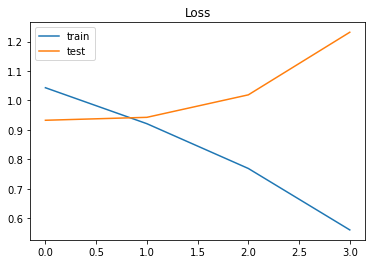

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

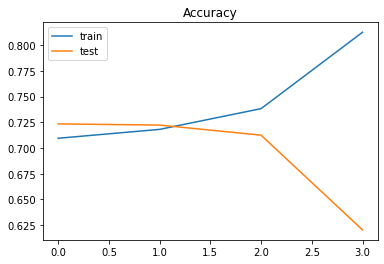

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [23]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
calc_train_error(X_train, Y_train, model)

0.04235414

In [28]:
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    val_predict = model.predict(X_test)
    mse = mean_squared_error(y_test, val_predict)
    rmse = np.sqrt(mse)
    return mse

In [29]:
calc_validation_error(X_test, Y_test, model)

0.09154575

In [19]:
new_bio_1 = ['I love my cat, he is beautiful and love the beach and going surfing on the weekends']
seq = tokenizer.texts_to_sequences(new_bio_1)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['desperately', 'rarely', 'not at all', 'socially', 'often', 'very often']
print(pred, labels[np.argmax(pred)])

[[0.00142955 0.01016717 0.08065417 0.0156106  0.8907245  0.00141402]] often


In [20]:
new_bio_2 = ['I dont drink much, I like to stay indoors and watch french drama films']
seq = tokenizer.texts_to_sequences(new_bio_2)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['desperately', 'rarely', 'not at all', 'socially', 'often', 'very often']
print(pred, labels[np.argmax(pred)])

[[6.8361015e-04 4.8318063e-03 1.5456575e-02 7.5412318e-03 9.7084463e-01
  6.4218859e-04]] often


In [21]:
new_bio_3 = ['I like fishing and running, while occassionally singing to the elderly']
seq = tokenizer.texts_to_sequences(new_bio_3)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['desperately', 'rarely', 'not at all', 'socially', 'often', 'very often']
print(pred, labels[np.argmax(pred)])

[[0.00155871 0.015449   0.01657599 0.03243196 0.93247235 0.00151196]] often


In [22]:
new_bio_4 = ['I am devoutly religious and want a boring exisistance in my home']
seq = tokenizer.texts_to_sequences(new_bio_4)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['desperately', 'rarely', 'not at all', 'socially', 'often', 'very often']
print(pred, labels[np.argmax(pred)])

[[0.0096163  0.10113715 0.07119603 0.19310932 0.6147216  0.01021963]] often
